# Position-switched Data Reduction
----------------------------------

This notebook shows how to use `dysh` to calibrate an OnOff observation.
It retrieves and calibrates position-switch scans using `GBTFITSLoad.getps()`, which returns a `ScanBlock` object.  OffOn observations can be reduced the same way.

In [21]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad

## First, we download the example SDFITS data, if necessary.


In [22]:
filename = "TGBT21A_501_11.raw.vegas.fits"
filename_saved = f"data/{filename}"
if not os.path.isfile(filename_saved):
    url = f"http://www.gb.nrao.edu/dysh/example_data/onoff-L/data/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename_saved)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded at {filename_saved}")

TGBT21A_501_11.raw.vegas.fits already downloaded


In [23]:
sdfits = GBTFITSLoad(filename_saved)
sdfits.info()

Filename: TGBT21A_501_11.raw.vegas.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   6040R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '32768E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


In [24]:
sdfits._index["DATE-OBS"]

0       2021-02-10T07:38:37.50
1       2021-02-10T07:38:37.50
2       2021-02-10T07:38:37.50
3       2021-02-10T07:38:37.50
4       2021-02-10T07:38:37.50
                 ...          
6035    2021-02-10T07:48:50.97
6036    2021-02-10T07:48:50.97
6037    2021-02-10T07:48:50.97
6038    2021-02-10T07:48:50.97
6039    2021-02-10T07:48:50.97
Name: DATE-OBS, Length: 6040, dtype: object

In [25]:
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,152,NGC2415,3784.0,OnOff,1,1.617185,1.420406,5,2,151,1,286.218008,41.62843
1,153,NGC2415,3784.0,OnOff,2,1.617185,1.420406,5,2,151,1,286.886521,41.118134


## Next we fetch and calibrate the Position Switched data
If you don't want to calibrate, add, `calibrate='false'`

In [26]:
psscan = sdfits.getps(scan=152, ifnum=0, plnum=0)

In [27]:
print(f"T_sys = {psscan[0].tsys.mean():.2f}")

T_sys = 17.17


### Create the time-averaged spectrum, using $T_{sys}$ weighting

In [28]:
ta = psscan.timeaverage(weights='tsys')

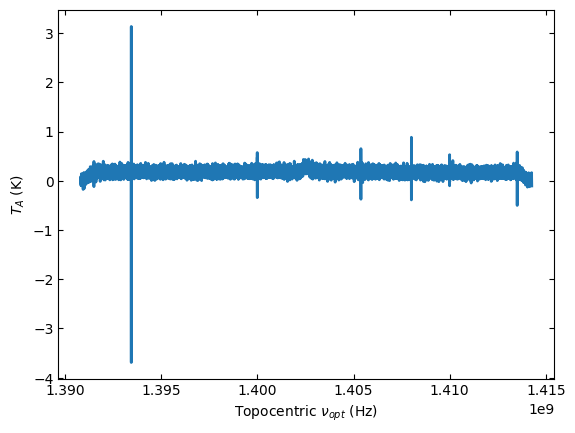

In [29]:
ta.plot()

### Change the axis units and ranges.

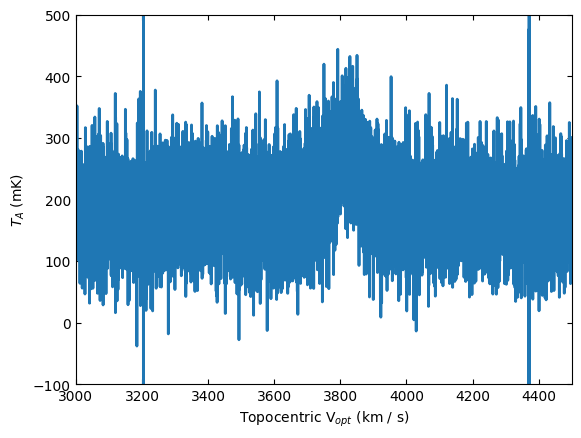

In [30]:
ta.plot(xaxis_unit="km/s",yaxis_unit="mK",ymin=-100,ymax=500,xmin=3000,xmax=4500)

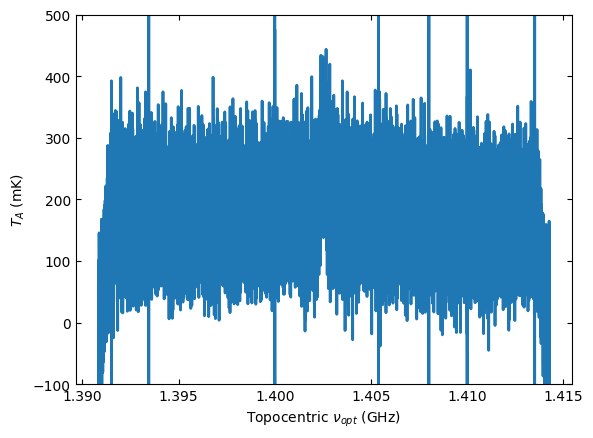

In [31]:
ta.plot(xaxis_unit="GHz",ymin=-100,ymax=500,yaxis_unit="mK")

In [32]:
kms = u.km/u.s
ta.baseline(degree=2,exclude=[3600*kms,4100*kms],remove=True)


EXCLUDING [Spectral Region, 1 sub-regions:
  (1401242184.363393 Hz, 1403551474.1090915 Hz) 
]


 [astropy.modeling.fitting]


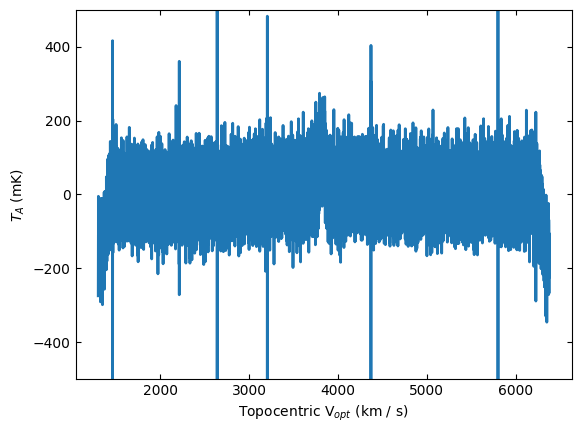

In [33]:
ta.plot(xaxis_unit="km/s",yaxis_unit="mK",ymin=-500,ymax=500,)

In [34]:
print(ta.baseline_model)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 2
Parameters:
             c0                   c1                    c2          
             K                  K / Hz               K / Hz2        
    ------------------- --------------------- ----------------------
    0.16984671749959518 6.155580315232285e-29 2.2305012033296116e-56


In [35]:
ta.savefig("output/baselined_removed.png")

---

## Now do calibration using selection instead

In [36]:
sdfits.select(scan=[152,153],ifnum=0)
sdfits.selection.show()

 ID    TAG       SCAN    IFNUM # SELECTED
--- --------- ---------- ----- ----------
  0 812a597ca [152, 153]     0       1208


In [37]:
sb=sdfits.getps(plnum=0)

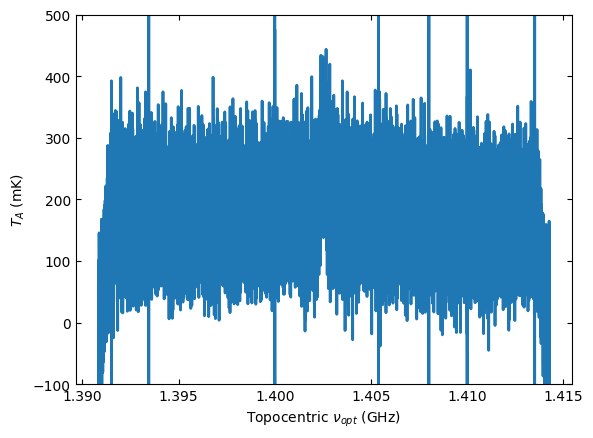

In [38]:
ta2=sb.timeaverage(weights='tsys')
ta2.plot(xaxis_unit="GHz",ymin=-100,ymax=500,yaxis_unit="mK")

### We can do the other polarization, with the scan numbers already selected.

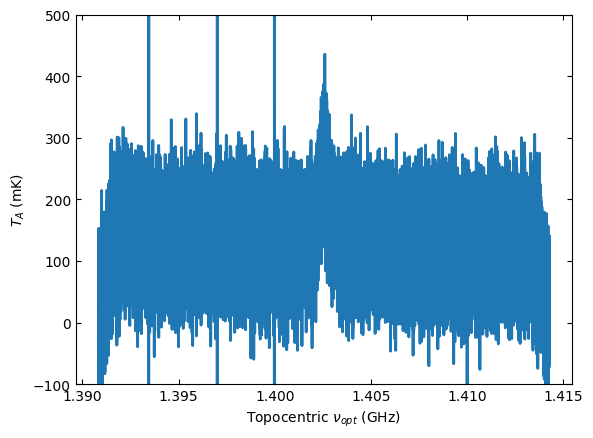

In [39]:
sb=sdfits.getps(plnum=1)
ta3=sb.timeaverage(weights='tsys')
ta3.plot(xaxis_unit="GHz",ymin=-100,ymax=500,yaxis_unit="mK")

### plot the average of the polarizations

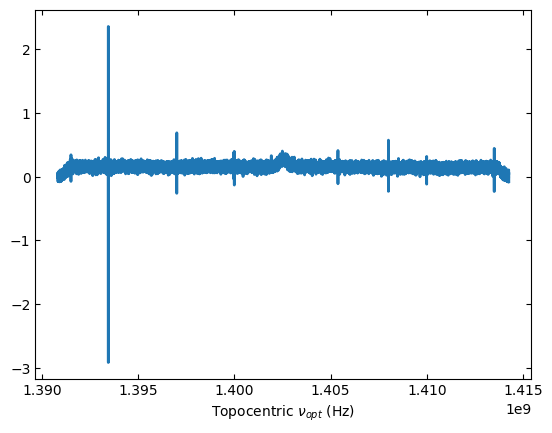

In [40]:
avg=ta2+ta3
avg *= 0.5
avg.plot()